<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/master/notebooks/Division_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the unified database



---



---



In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/master/datasets/dataset_resampled.csv"
df=pd.read_csv(raw_data_url, index_col=False)

categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df = df.drop_duplicates()
df = df.dropna()

df['DATE'] = pd.to_datetime(df['DATE'], 
               format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1996
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_REF            1997 non-null   string        
 1   ID_SITE_RATTACHE  1997 non-null   string        
 2   QUANTITY          1997 non-null   float64       
 3   CODE_ATC          1997 non-null   string        
 4   HOSPI_CODE_UCD    1997 non-null   string        
 5   N_UFS             1997 non-null   int64         
 6   N_ETB             1997 non-null   int64         
 7   POPULATION        1997 non-null   float64       
 8   P_MEDICAL         1997 non-null   int64         
 9   PN_MEDICAL        1997 non-null   int64         
 10  LIT_HC            1997 non-null   float64       
 11  LIT_HP            1997 non-null   float64       
 12  SEJ_MCO           1997 non-null   int64         
 13  SEJ_HAD           1997 non-null   int64         
 14  SEJ_PSY           1997 n

In [52]:
for column in numerical_features:
  zeros = (df[column] == 0).sum()
  print(f'Column: {column}' + f' number of zeros: {zeros}')

Column: N_UFS number of zeros: 0
Column: QUANTITY number of zeros: 0
Column: N_ETB number of zeros: 0
Column: POPULATION number of zeros: 0
Column: P_MEDICAL number of zeros: 0
Column: PN_MEDICAL number of zeros: 0
Column: LIT_HC number of zeros: 0
Column: LIT_HP number of zeros: 0
Column: SEJ_MCO number of zeros: 0
Column: SEJ_HAD number of zeros: 1473
Column: SEJ_PSY number of zeros: 459
Column: SEJ_SSR number of zeros: 0


In [51]:
# Separating databases

n_medicines = df['ID_REF'].nunique()
print('Number of different medicines: ', n_medicines)

df_h1 = df[df["ID_SITE_RATTACHE"] == "HOSPI_1"]
df_h2 = df[df["ID_SITE_RATTACHE"] == "HOSPI_2"]
df_h3 = df[df["ID_SITE_RATTACHE"] == "HOSPI_3"]
df_h4 = df[df["ID_SITE_RATTACHE"] == "HOSPI_4"]

Number of different medicines:  84


# Helper functions

In [45]:
def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [49]:
def visualize_distribution(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = m.ceil(num_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        ax = axes[i // n_cols, i % n_cols]
        sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [71]:
def display_unique(df):
  features = df.columns
  for column in features:
    print(f'\n Unique values of feature: {column}')
    print(df[column].unique())
    print('\n')

## Hospital 1

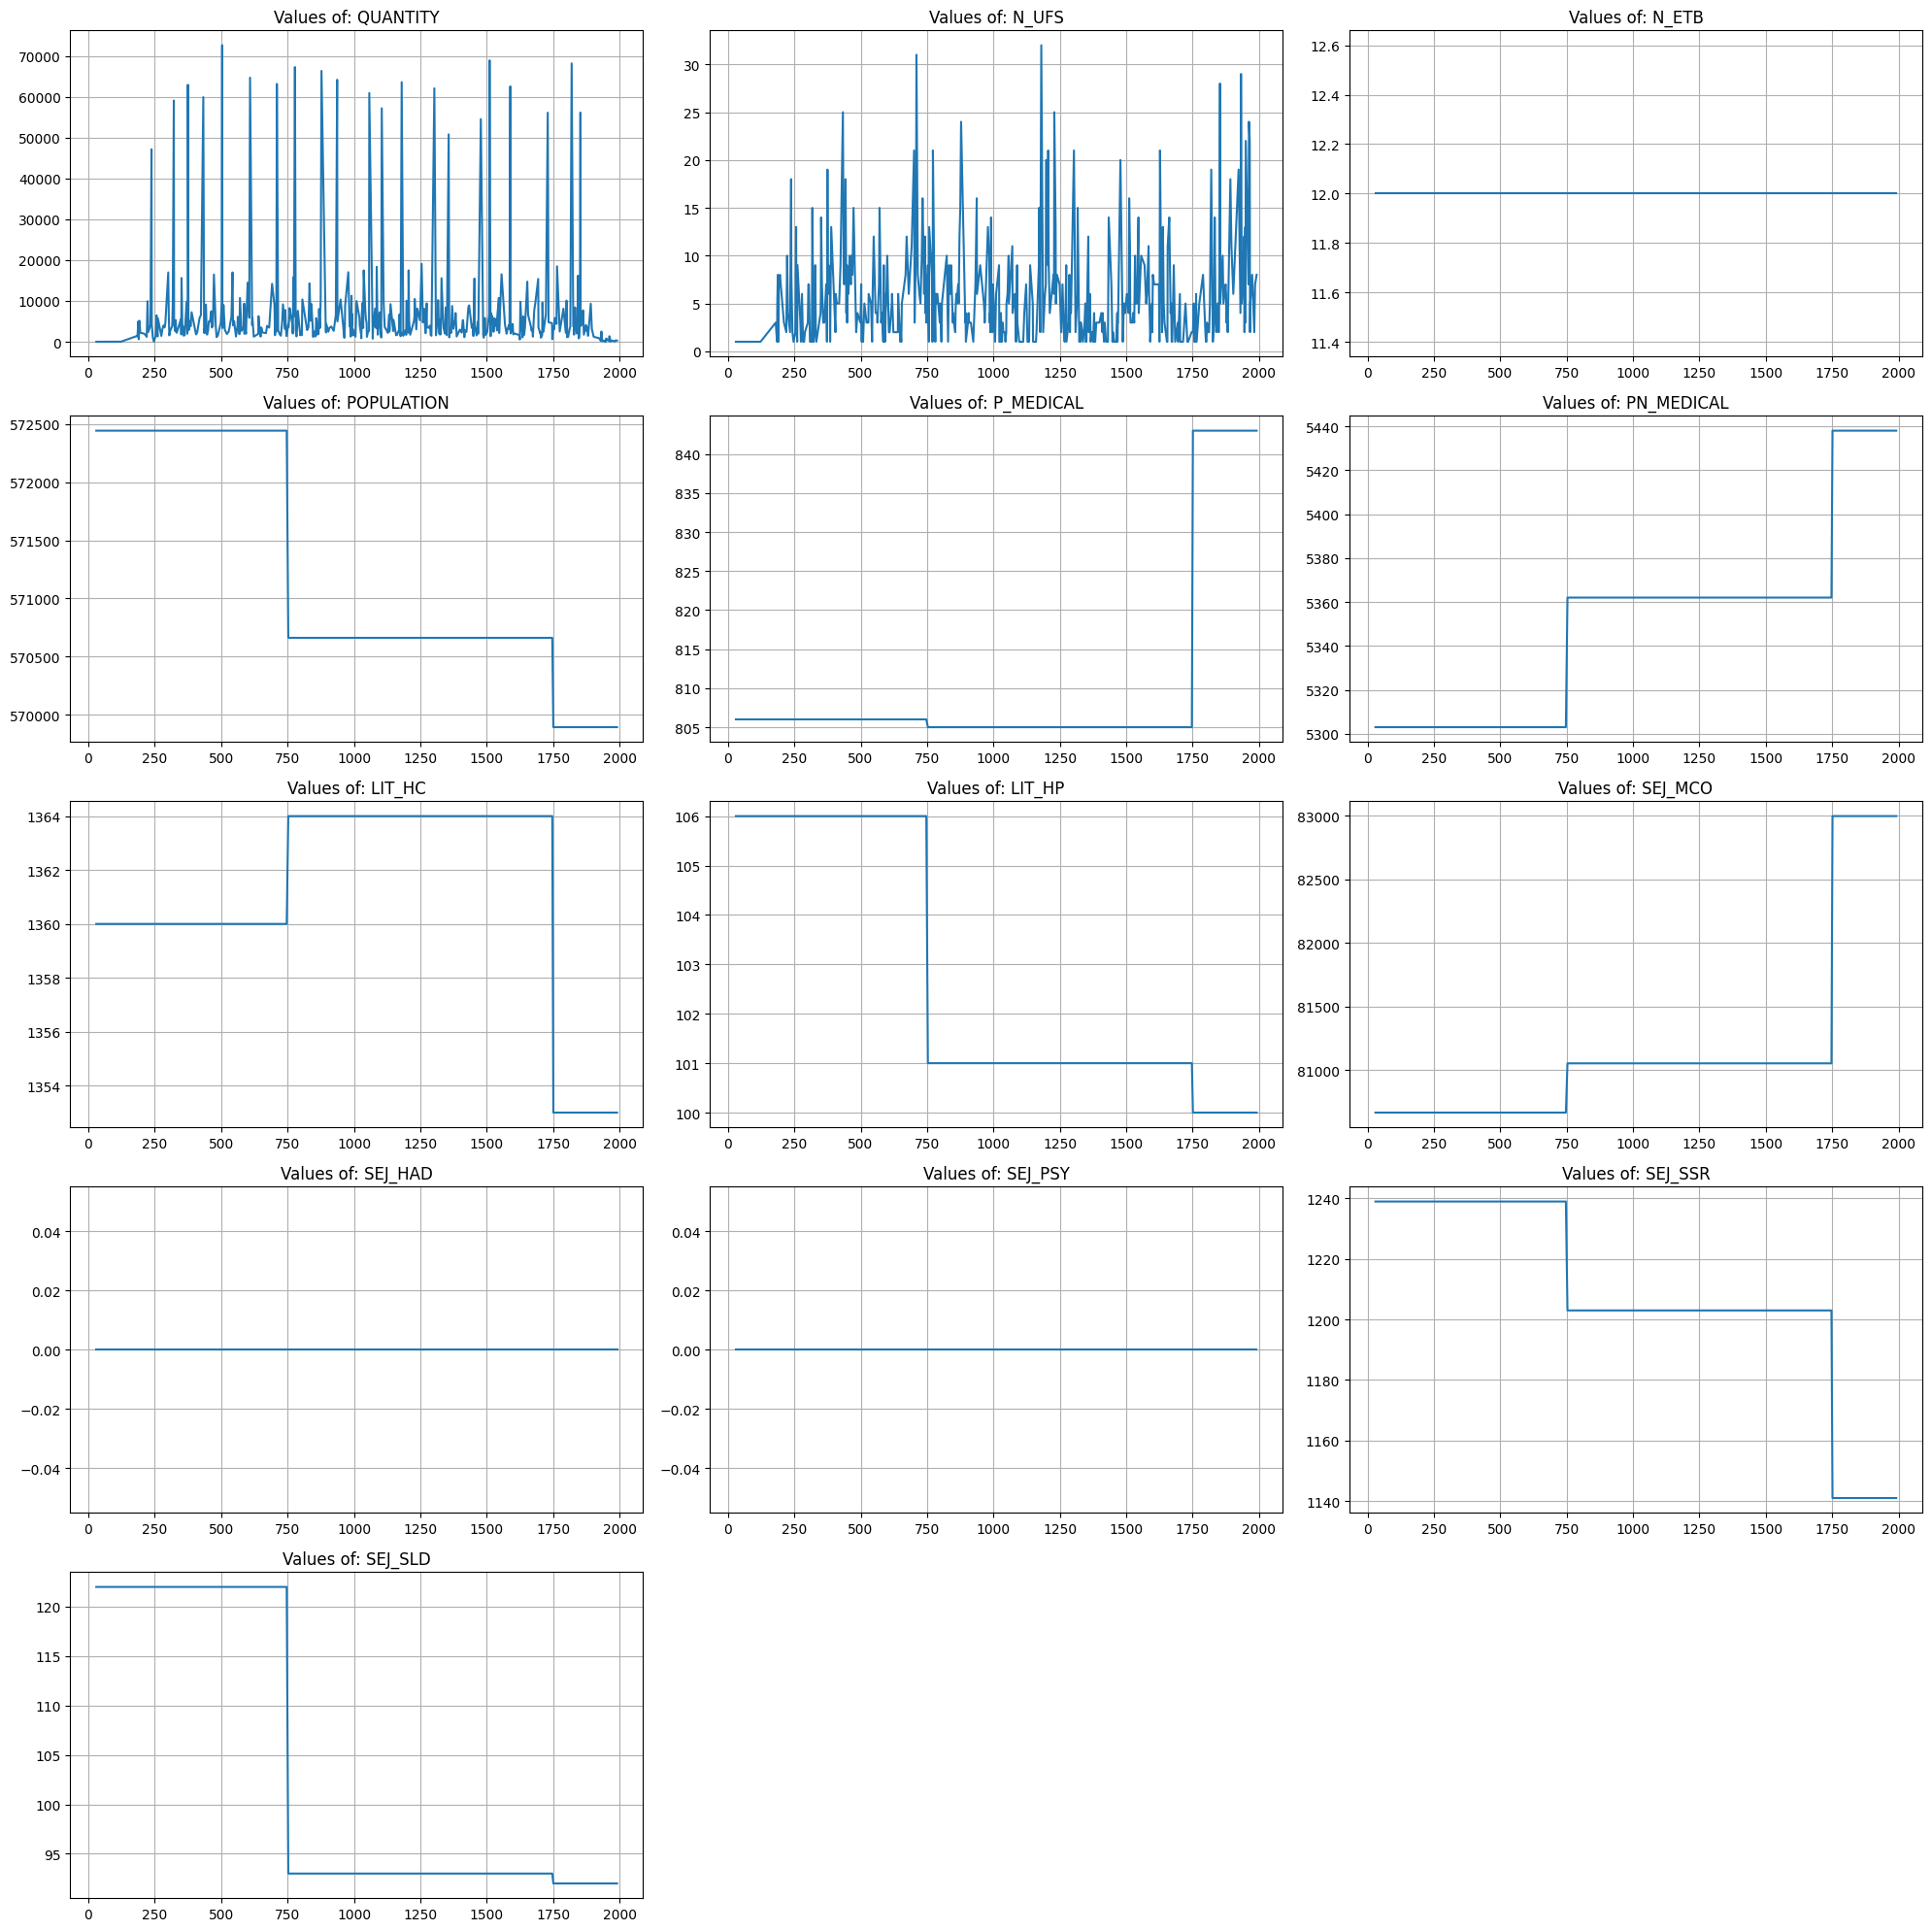

In [46]:
# Visualizing values of numerical features
plot_df(df_h1)

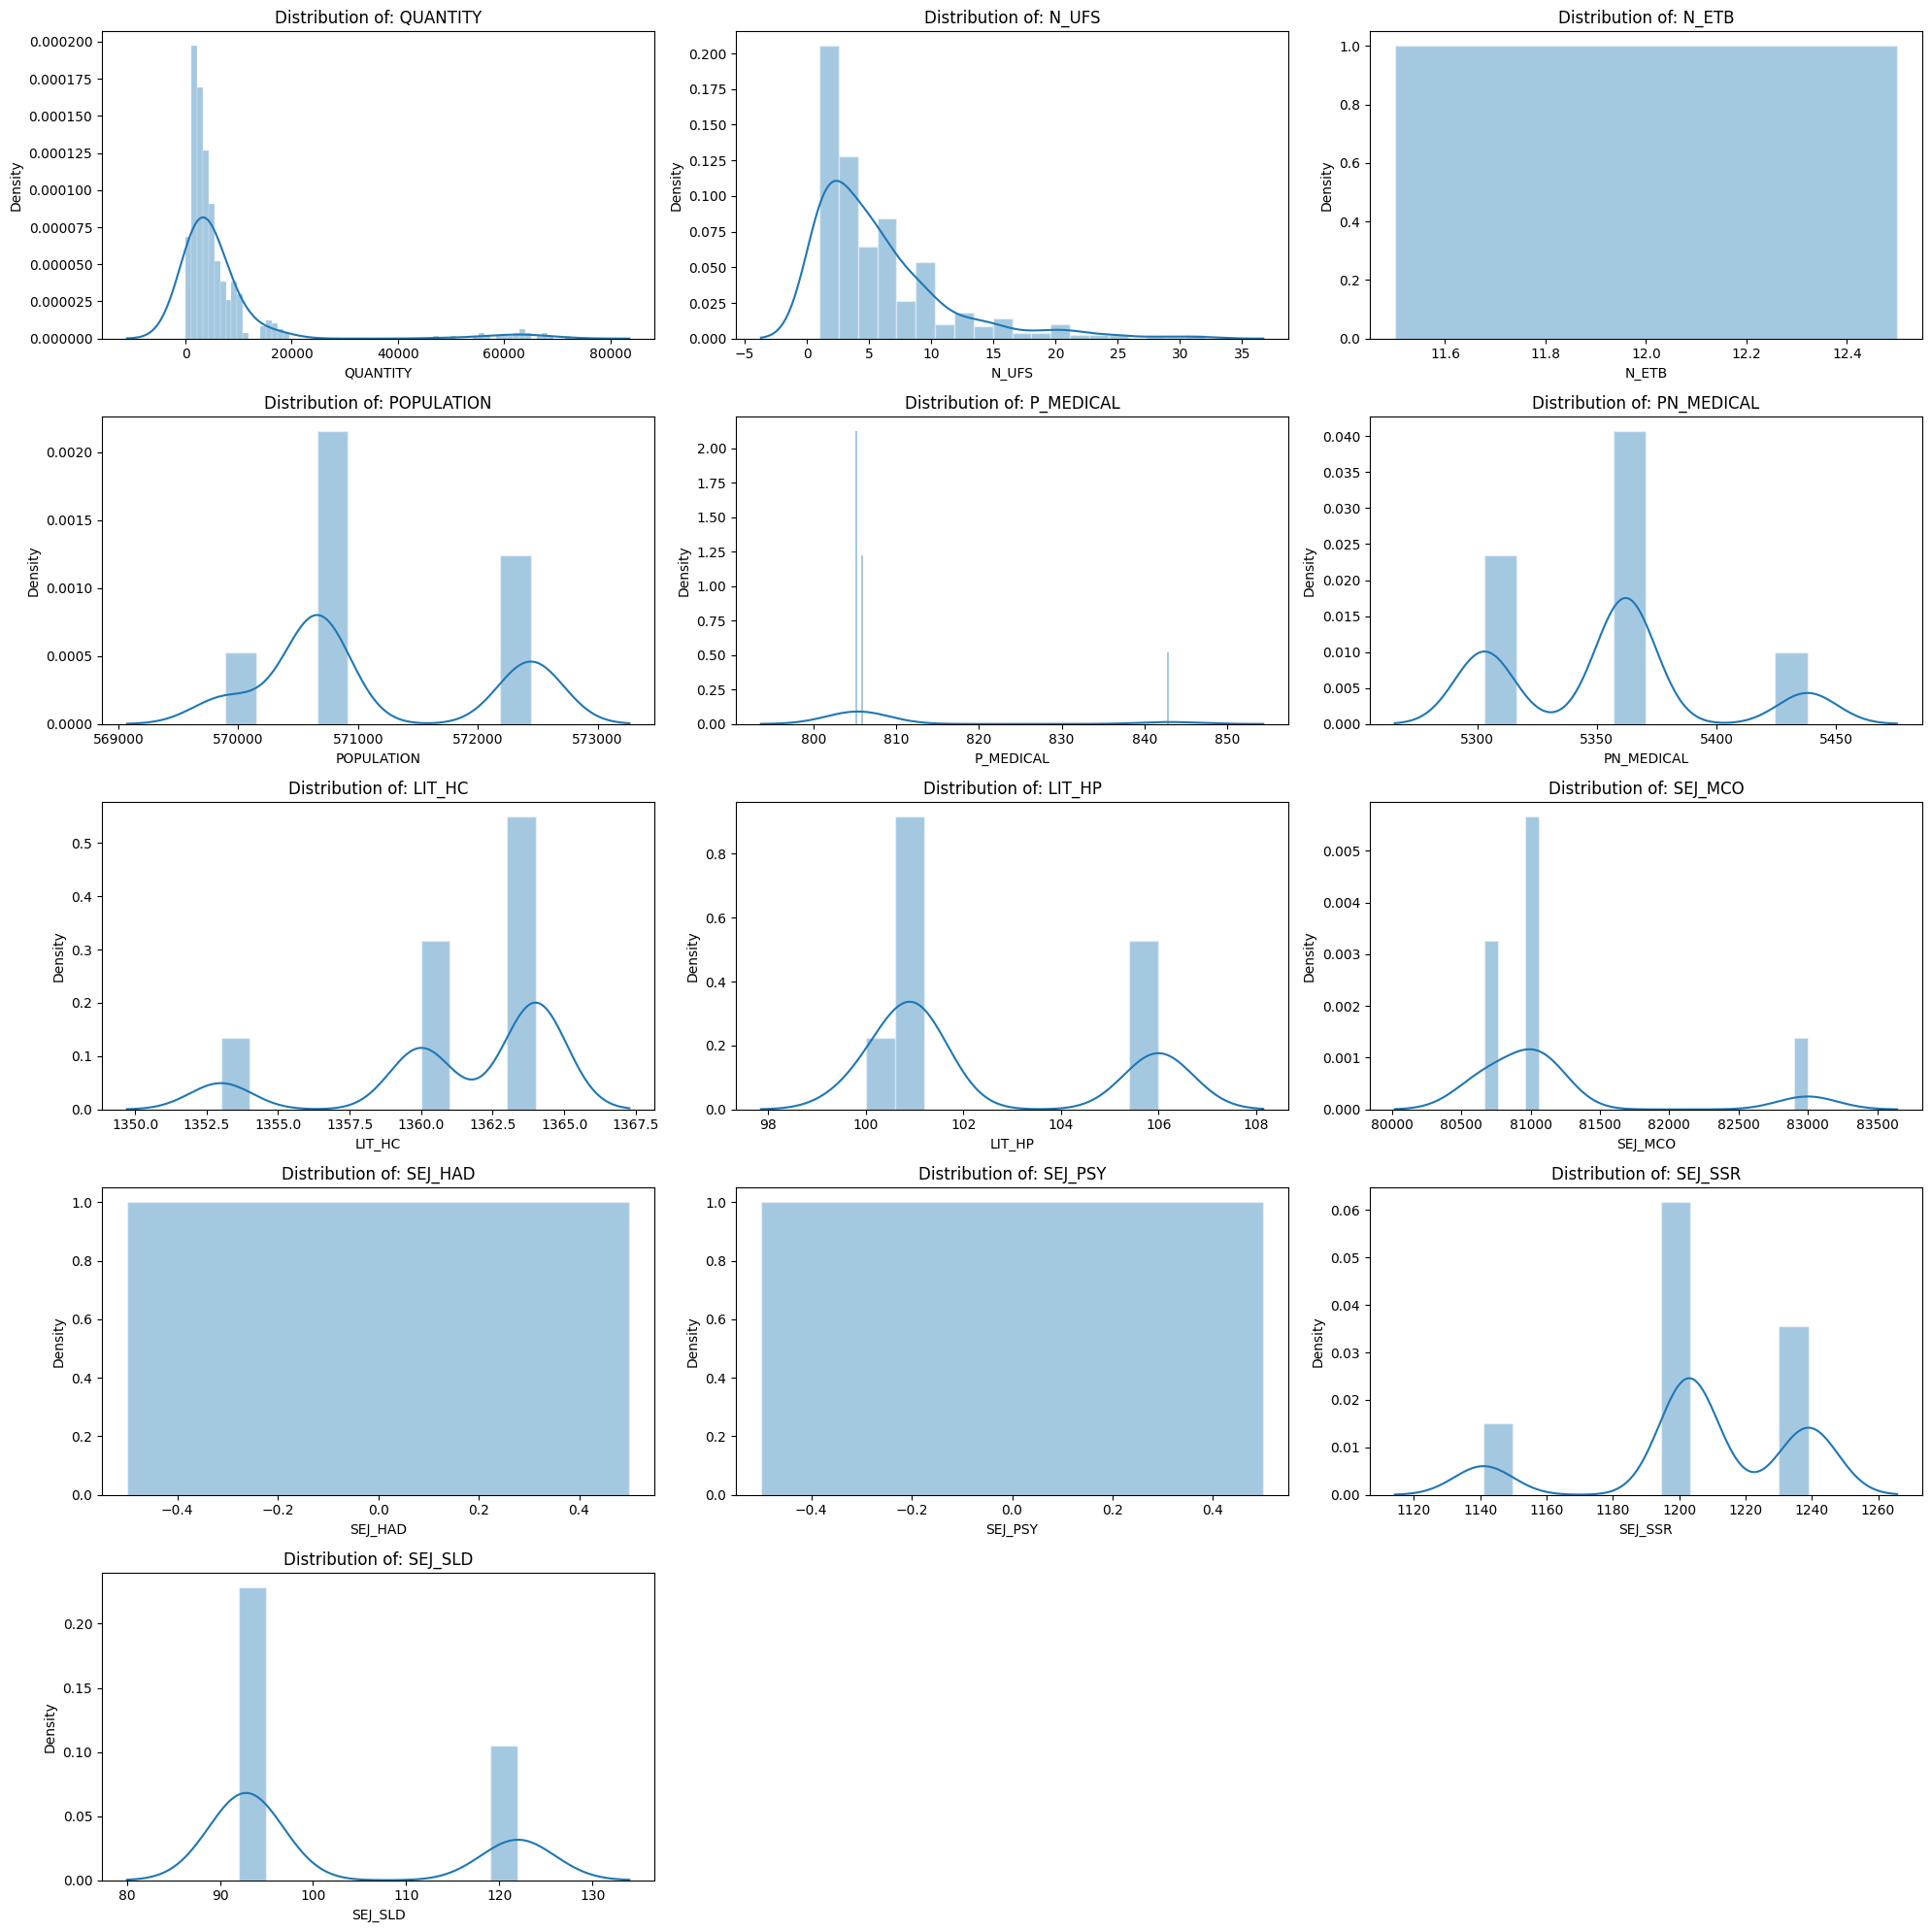

In [50]:
visualize_distribution(df_h1)

# Correlation analysis

In [62]:
pd.set_option('mode.chained_assignment', None)

df_h1["ID_REF"] = df_h1["ID_REF"].astype(int)
df_h1["HOSPI_CODE_UCD"] = df_h1["HOSPI_CODE_UCD"].astype(int)

change = {'N02BE01':'1','A12BA01':'2','B05XA03':'3',
          'B01AB05':'4','B01AC06':'5','N05BA04':'6',
          'N02AX02':'7','N05CF01':'8','R03AC02':'9',
          'H02AB06':'10','A03AX12':'11','N05BA12':'12',
          'B05XA09':'13','M03BX01':'14','C01CA03':'15',
          'N05CF02':'16','C03CA01':'17','J01CR05':'18'}

df_h1["CODE_ATC"] = df_h1['CODE_ATC'].replace(change)
df_h1["CODE_ATC"] = df_h1["CODE_ATC"].astype(int)

<ipython-input-76-1f6037c769db>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_h1.corr()


<Axes: >

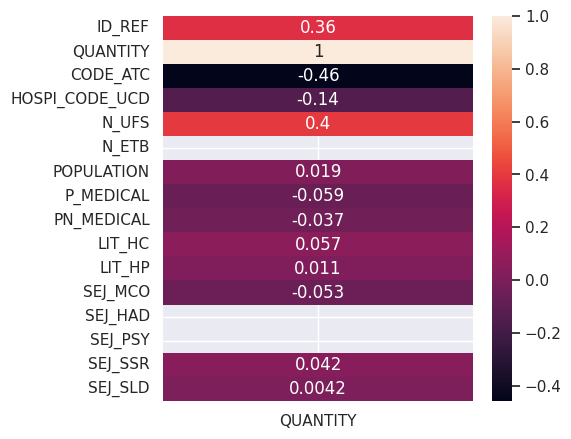

In [76]:
corr = df_h1.corr()
x = corr[['QUANTITY']]
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(x,annot=True)

<Axes: >

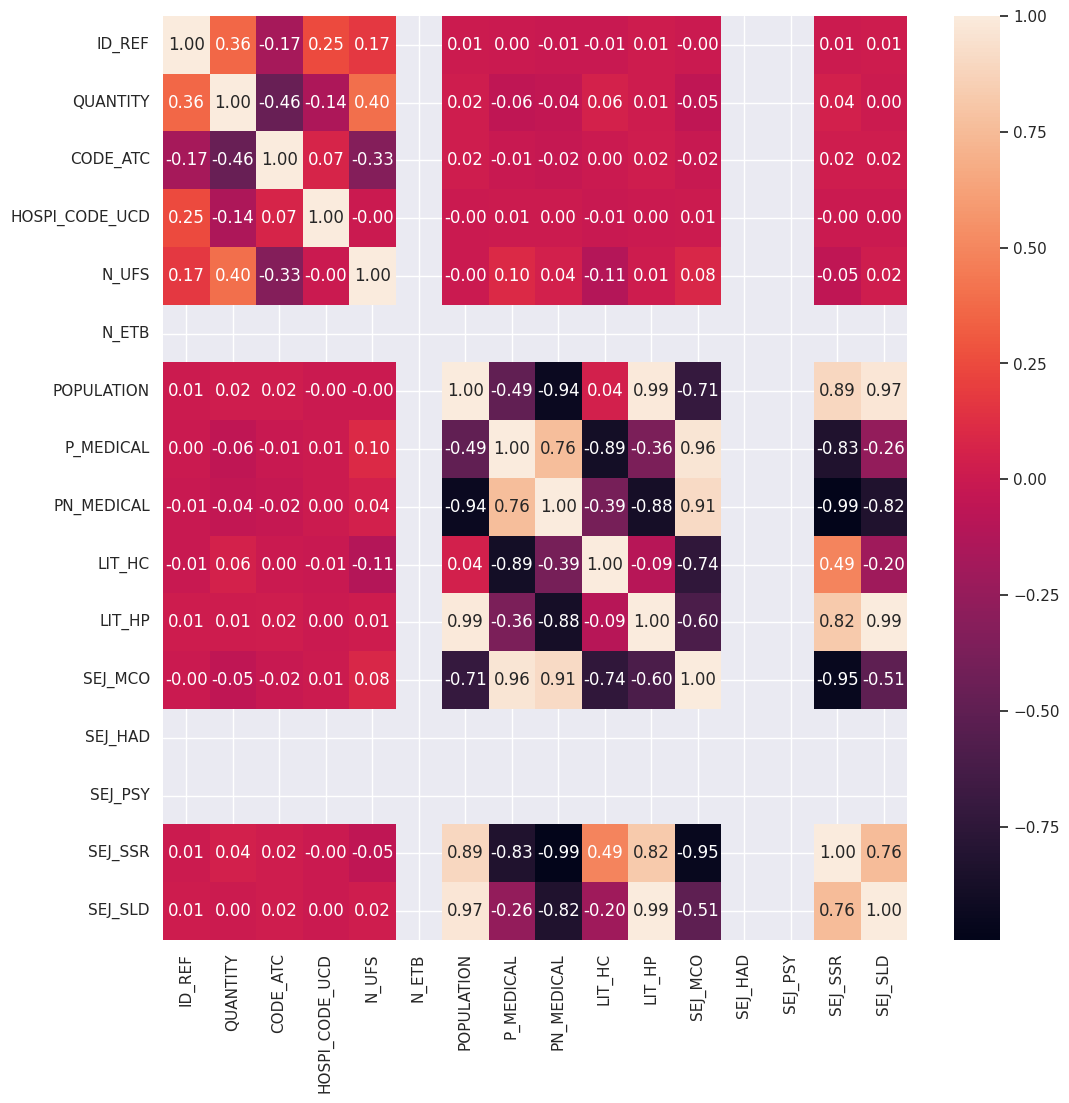

In [79]:
'''
  The constant values are not displayed in the correlation.
'''
corr = df_h1.corr(numeric_only=True)
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, annot=True, fmt='.2f')
